# チャートパターンの検出 (ChatGPT)

In [1]:
# ライブラリのインポート
import pandas as pd
import numpy as np
from datetime import date, datetime, timedelta
import matplotlib.pyplot as plt
import yfinance as yf
from scipy.signal import argrelextrema
import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)

## 共通設定

In [2]:
# 共通設定
ticker = "4519.T"
# str_prodはデータを取得する期間（例: 1d、5d、1mo、3mo、1y、2y、5y、10y、ytd、max）
str_prod = "12mo"
# str_itvlはデータの間隔（例: 1m、2m、5m、15m、30m、60m、90m、1h、1d、5d、1wk、1mo、3mo）
str_itvl = "1d"
# nwは局所最大・最小探索における近傍の幅
nw = 5

## データ獲得とローカル高値・安値計算関数

In [3]:
# データ獲得とローカル高値・安値計算関数
def local_min_max(ticker, str_prod, str_itvl, nwindow=5):
    # データ取得
    df = yf.download(ticker, period=str_prod, interval=str_itvl, multi_level_index=False)
    df = df.dropna().reset_index()
    # ローカル高値・安値の検出
    n = nwindow  # 窓幅
    highs = df['High'].values
    lows = df['Low'].values
    local_min = argrelextrema(lows, np.less, order=n)[0]
    local_max = argrelextrema(highs, np.greater, order=n)[0]
    return df, local_min, local_max

## ダブルトップ検出

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


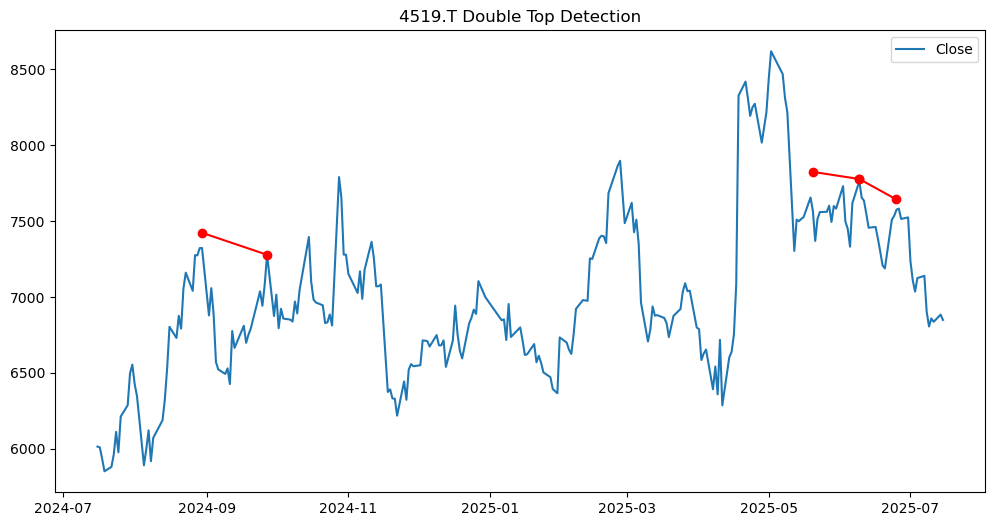

In [4]:
# ダブルトップ検出
def detect_double_top(df, peaks, tolerance=0.02):
    patterns = []
    for i in range(len(peaks) - 1):
        h1 = df.iloc[peaks[i]]['High']
        h2 = df.iloc[peaks[i+1]]['High']
        if abs(h1 - h2) / h1 < tolerance:
            patterns.append((peaks[i], peaks[i+1]))
    return patterns

df,local_min,local_max = local_min_max(ticker, str_prod, str_itvl, nwindow=nw)
double_tops = detect_double_top(df, local_max)

# 可視化
plt.figure(figsize=(12, 6))
plt.plot(df['Date'], df['Close'], label='Close')
for p1, p2 in double_tops:
    plt.plot([df['Date'][p1], df['Date'][p2]], [df['High'][p1], df['High'][p2]], 'ro-')
plt.title(ticker+' Double Top Detection')
plt.legend()
plt.show()

## ヘッドアンドショルダー検出（簡易ロジック）

[*********************100%***********************]  1 of 1 completed


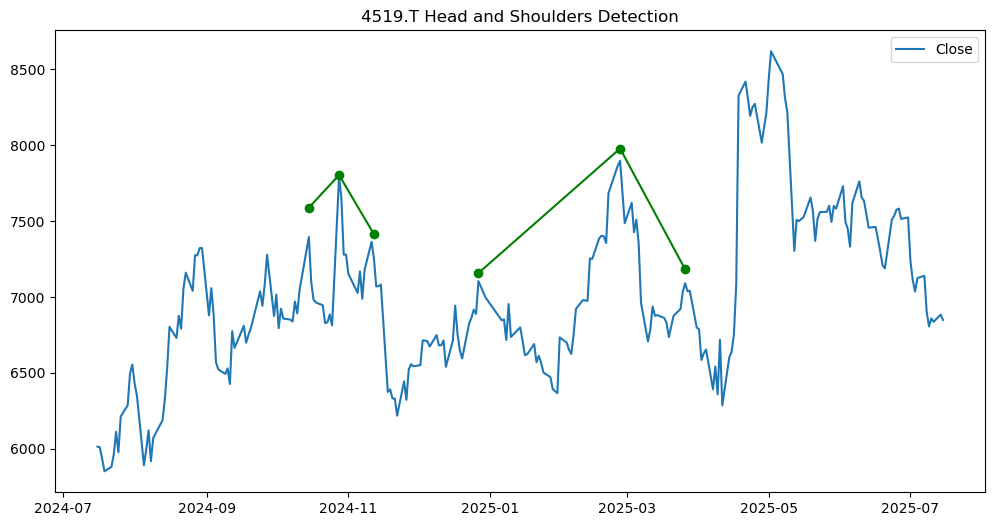

In [5]:
# ヘッドアンドショルダー検出
def detect_head_and_shoulders(df, peaks, tolerance=0.05):
    patterns = []
    for i in range(len(peaks) - 2):
        l, m, r = peaks[i], peaks[i+1], peaks[i+2]
        hl, hm, hr = df['High'][l], df['High'][m], df['High'][r]
        if hm > hl and hm > hr and abs(hl - hr) / hm < tolerance:
            patterns.append((l, m, r))
    return patterns

df,local_min,local_max = local_min_max(ticker, str_prod, str_itvl, nwindow=nw)
head_shoulders = detect_head_and_shoulders(df, local_max)

# 可視化
plt.figure(figsize=(12, 6))
plt.plot(df['Date'], df['Close'], label='Close')
for l, m, r in head_shoulders:
    plt.plot([df['Date'][l], df['Date'][m], df['Date'][r]], [df['High'][l], df['High'][m], df['High'][r]], 'go-')
plt.title(ticker+' Head and Shoulders Detection')
plt.legend()
plt.show()

## トライアングルパターン（高値・安値の収束）

[*********************100%***********************]  1 of 1 completed


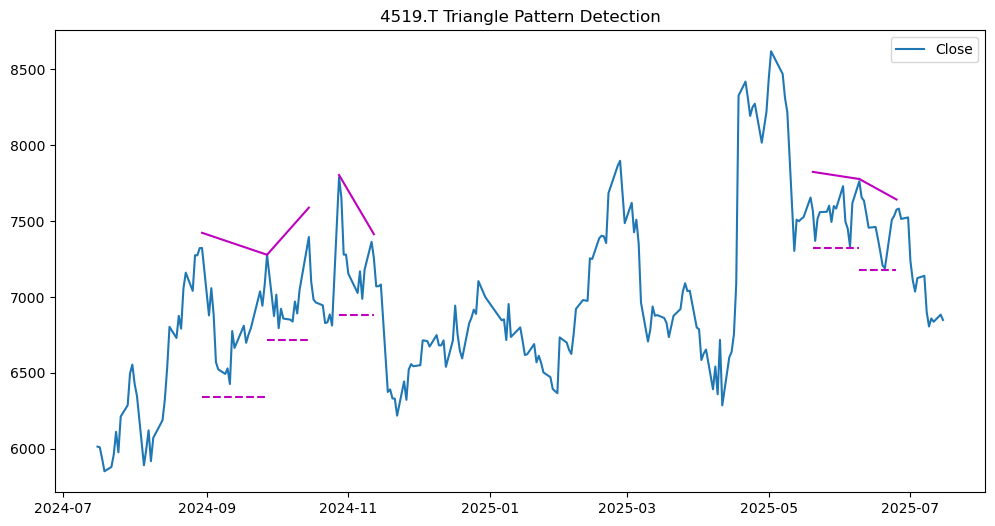

In [6]:
# トライアングルパターン検出
def detect_triangle(df, peaks, troughs, min_len=10, tolerance=0.05):
    triangles = []
    for i in range(len(peaks) - 1):
        p1, p2 = peaks[i], peaks[i+1]
        t_candidates = [t for t in troughs if p1 < t < p2]
        if len(t_candidates) >= 1:
            hl1, hl2 = df['High'][p1], df['High'][p2]
            ll1, ll2 = df['Low'][t_candidates[0]], df['Low'][t_candidates[-1]]
            if abs(hl1 - hl2) / hl1 < tolerance and abs(ll1 - ll2) / ll1 < tolerance:
                if p2 - p1 >= min_len:
                    triangles.append((p1, t_candidates[0], p2))
    return triangles

df,local_min,local_max = local_min_max(ticker, str_prod, str_itvl, nwindow=nw)
troughs = argrelextrema(df['Low'].values, np.less, order=5)[0]
triangles = detect_triangle(df, local_max, troughs)

# 可視化
plt.figure(figsize=(12, 6))
plt.plot(df['Date'], df['Close'], label='Close')
for p1, t, p2 in triangles:
    plt.plot([df['Date'][p1], df['Date'][p2]], [df['High'][p1], df['High'][p2]], 'm-')
    plt.plot([df['Date'][p1], df['Date'][p2]], [df['Low'][t], df['Low'][t]], 'm--')
plt.title(ticker+' Triangle Pattern Detection')
plt.legend()
plt.show()

##  ペナント（ペナント型・フラッグ型）検出（簡易版）

[*********************100%***********************]  1 of 1 completed


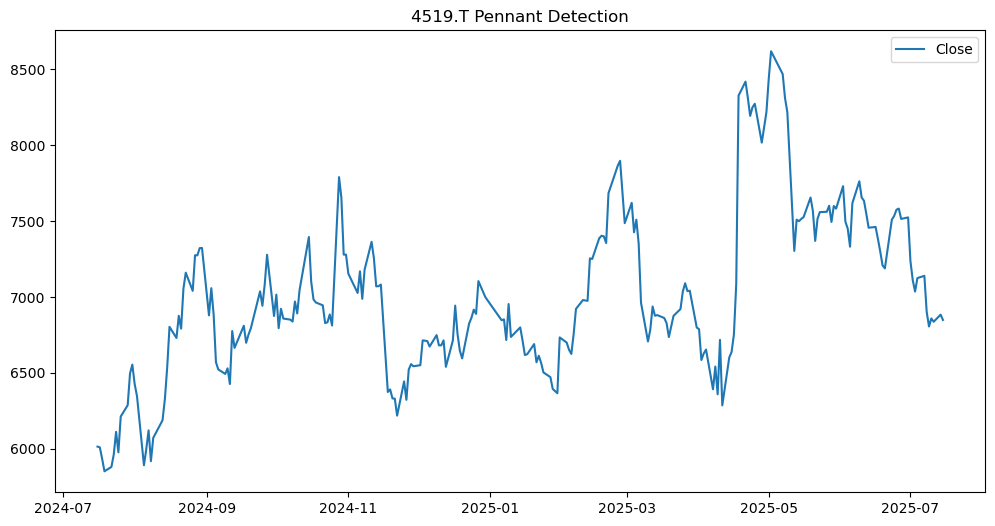

In [7]:
def detect_pennant(df, peaks, troughs, tolerance=0.05):
    patterns = []
    for i in range(len(peaks) - 1):
        p1, p2 = peaks[i], peaks[i+1]
        t_candidates = [t for t in troughs if p1 < t < p2]
        if len(t_candidates) < 2:
            continue
        h1, h2 = df['High'][p1], df['High'][p2]
        l1, l2 = df['Low'][t_candidates[0]], df['Low'][t_candidates[-1]]
        if abs(h1 - h2) / h1 < tolerance and abs(l1 - l2) / l1 < tolerance:
            # 前に急騰があるか（フラグポール）
            if p1 > 10 and df['Close'][p1] > df['Close'][p1 - 10] * 1.1:
                patterns.append((p1 - 10, p1, p2))
    return patterns

df,local_min,local_max = local_min_max(ticker, str_prod, str_itvl, nwindow=nw)
pennants = detect_pennant(df, local_max, troughs)

# 可視化
plt.figure(figsize=(12, 6))
plt.plot(df['Date'], df['Close'], label='Close')
for base, p1, p2 in pennants:
    plt.plot([df['Date'][base], df['Date'][p1]], [df['Close'][base], df['Close'][p1]], 'g--')  # フラグポール
    plt.plot([df['Date'][p1], df['Date'][p2]], [df['High'][p1], df['High'][p2]], 'r-')        # 上辺
    plt.plot([df['Date'][p1], df['Date'][p2]], [df['Low'][p1], df['Low'][p2]], 'r--')         # 下辺
plt.title(ticker+' Pennant Detection')
plt.legend()
plt.show()

## カップ・ウィズ・ハンドル検出（簡易版）

[*********************100%***********************]  1 of 1 completed


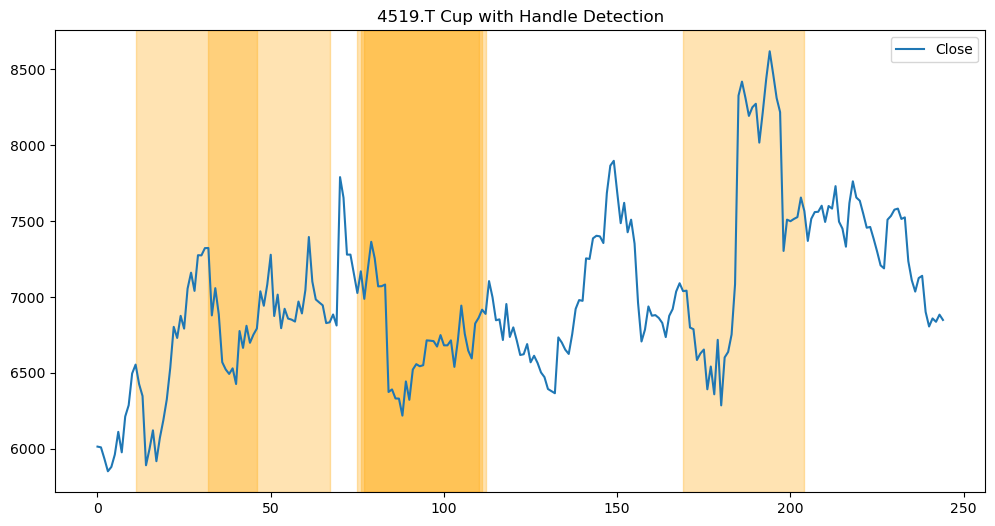

In [8]:
def detect_cup_with_handle(df, window=30, handle_len=5, tolerance=0.05):
    patterns = []
    for i in range(window, len(df) - handle_len):
        cup = df['Close'].iloc[i - window:i]
        min_idx = cup.idxmin()
        if min_idx == cup.index[0] or min_idx == cup.index[-1]:
            continue  # U字型の底が中央にない場合除外
        left = cup.iloc[0]
        right = cup.iloc[-1]
        bottom = cup.min()
        if abs(left - right) / left < tolerance and (left - bottom) / left > 0.1:
            handle = df['Close'].iloc[i:i + handle_len]
            if handle.max() < cup.max():  # ハンドルは控えめであるべき
                patterns.append((i - window, i + handle_len))
    return patterns

df,local_min,local_max = local_min_max(ticker, str_prod, str_itvl, nwindow=nw)
cup_handles = detect_cup_with_handle(df)

# 可視化
plt.figure(figsize=(12, 6))
plt.plot(df['Close'], label='Close')
for start, end in cup_handles:
    plt.axvspan(df.index[start], df.index[end], color='orange', alpha=0.3)
plt.title(ticker+' Cup with Handle Detection')
plt.legend()
plt.show()

## 厳密版の関数

In [9]:
#  強化版1：ダブルトップ検出（ネックライン＋戻りの浅さを考慮）
def detect_double_top_strict(df, peaks, tolerance=0.02, min_separation=5):
    patterns = []
    for i in range(len(peaks) - 1):
        idx1, idx2 = peaks[i], peaks[i+1]
        if idx2 - idx1 < min_separation:
            continue
        h1, h2 = df['High'][idx1], df['High'][idx2]
        # 高値の類似性確認
        if abs(h1 - h2) / h1 < tolerance:
            # 間にある谷の安値（ネックライン）
            valley_idx = df['Low'].iloc[idx1:idx2].idxmin()
            neck = df['Low'].loc[valley_idx]
            # ブレイク確認：直近の終値がネックラインを割る
            if df['Close'].iloc[idx2:].min() < neck:
                patterns.append((idx1, valley_idx, idx2))
    return patterns

In [10]:
# 強化版2：ヘッドアンドショルダー（左右対称性とネックラインブレイク）
def detect_head_and_shoulders_strict(df, peaks, tolerance=0.05):
    patterns = []
    for i in range(len(peaks) - 2):
        l, m, r = peaks[i], peaks[i+1], peaks[i+2]
        hl, hm, hr = df['High'][l], df['High'][m], df['High'][r]
        if hl < hm and hr < hm and abs(hl - hr) / hm < tolerance:
            # ネックライン = 両谷の安値の平均
            left_valley = df['Low'][l:m].min()
            right_valley = df['Low'][m:r].min()
            neckline = (left_valley + right_valley) / 2
            # ネックラインブレイク
            if df['Close'].iloc[r:].min() < neckline:
                patterns.append((l, m, r))
    return patterns

In [11]:
# 強化版3：ペナント検出（ポール＋対称三角＋ブレイク確認）
def detect_pennant_strict(df, peaks, troughs, window=15, tolerance=0.05):
    patterns = []
    for i in range(10, len(df) - window):
        pre_window = df['Close'].iloc[i-10:i]
        post_window = df['Close'].iloc[i:i+window]
        # ポール条件（前方に急騰があるか）
        if pre_window[-1] > pre_window[0] * 1.15:
            # 高値・安値の収束（三角持ち合い）
            high_start = post_window[:5].max()
            high_end = post_window[-5:].max()
            low_start = post_window[:5].min()
            low_end = post_window[-5:].min()
            high_converging = abs(high_start - high_end) / high_start < tolerance
            low_converging = abs(low_start - low_end) / low_start < tolerance
            if high_converging and low_converging:
                # ブレイク確認（上抜け）
                if df['Close'].iloc[i+window:i+window+5].max() > high_end:
                    patterns.append((i-10, i+window))
    return patterns

In [12]:
# 強化版4：カップ・ウィズ・ハンドル（左右対称 + ハンドルの下落率）
def detect_cup_with_handle_strict(df, window=40, handle_len=5, tolerance=0.05):
    patterns = []
    for i in range(window, len(df) - handle_len):
        cup = df['Close'].iloc[i - window:i]
        min_idx = cup.idxmin()
        if min_idx == cup.index[0] or min_idx == cup.index[-1]:
            continue
        left = cup.iloc[0]
        right = cup.iloc[-1]
        bottom = cup.min()
        # 左右対称性と深さチェック
        if abs(left - right) / left < tolerance and (left - bottom) / left > 0.12:
            handle = df['Close'].iloc[i:i + handle_len]
            # ハンドルは10%未満の軽い調整
            if handle.max() < cup.max() and (handle.max() - handle.min()) / handle.max() < 0.1:
                # ハンドル後の上昇を確認
                if df['Close'].iloc[i + handle_len:i + handle_len + 5].max() > cup.max():
                    patterns.append((i - window, i + handle_len))
    return patterns